In [1]:
%%capture
import sys

is_in_colab = 'google.colab' in sys.modules

if is_in_colab:
  from google.colab import drive
  drive.mount('/content/drive')

  %cd /content/drive/MyDrive/KU_NLP
  !pip install -r requirements.txt

# 2. Representation Learning

In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from enum import Enum

from models.answer_exists_models import *

import fasttext
import fasttext.util


import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import compress_fasttext
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
!pip install compress-fasttext

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
class Annotation_error(Enum):
    UNANSWERED = -1
    BAD_TOKENIZATION_OR_DATA = -2
    IGNORED = -3

In [6]:
path_train_set = "data/train_set_stanza.pkl"
path_validation_set = "data/validation_set_stanza.pkl"

In [7]:
train_set = pd.read_pickle(path_train_set)
validation_set = pd.read_pickle(path_validation_set)

In [8]:
train_en = train_set[train_set["language"] == "english"]
train_fi = train_set[train_set["language"] == "finnish"]
train_ja = train_set[train_set["language"] == "japanese"]

validation_en = validation_set[validation_set["language"] == "english"]
validation_fi = validation_set[validation_set["language"] == "finnish"]
validation_ja = validation_set[validation_set["language"] == "japanese"]

# 2a.

In [9]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED


In [10]:
# If the question is answered, then predict "1". Otherwise predict "0".
def get_target(data):
    answer_set = data['document_answer_region']
    y = np.empty(answer_set.shape[0], dtype=np.int32)

    for i, answer in enumerate(answer_set):
        if type(answer) == Annotation_error and answer == Annotation_error.UNANSWERED: # @TODO: if we don't do the annotation stuff, then we can check for -1 here
            y[i] = 0
        else:
            y[i] = 1
    return y

In [184]:
def collate_batch(raw_batch): #-> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_data: The combined input_ids, seq_lens, and labels for the batch
    :return: A tuple of tensors (input_ids, seq_lens, labels)
    """
    
    assert pad_id != None
    
    question_sequence_lengths = [sample[1] for sample in raw_batch]
    question_max_length = max(question_sequence_lengths)
    question_ids = [(sample[0] + [pad_id] * (question_max_length - len(sample[0]))) for sample in raw_batch]
    assert (all(len(i) == question_max_length for i in question_ids))
    
    document_sequence_lengths = [sample[3] for sample in raw_batch]
    document_max_length = max(document_sequence_lengths)
    document_ids = [(sample[2] + [pad_id] * (document_max_length - len(sample[2]))) for sample in raw_batch]
    assert (all(len(i) == document_max_length for i in document_ids))
    
    targets = [sample[4] for sample in raw_batch]

    return torch.tensor(question_ids), torch.tensor(question_sequence_lengths), torch.tensor(document_ids), torch.tensor(document_sequence_lengths), torch.tensor(targets, dtype=torch.long)


In [185]:
train_en

,language,question,document_title,document,document_answer_region
0,english,"[When, was, quantum, field, theory, developed, ?]","[Quantum, field, theory]","[Quantum, field, theory, naturally, began, wit...","(26, 26)"
1,english,"[Who, was, the, first, Nobel, prize, winner, f...","[List, of, Nobel, laureates, in, Literature]","[The, Nobel, Prize, in, Literature, (, Swedish...","(12, 13)"
2,english,"[When, is, the, dialectical, method, used, ?]",[Dialectic],"[Dialectic, or, dialectics, (, Greek, :, διαλε...","(27, 49)"
3,english,"[Who, invented, Hangul, ?]","[Origin, of, Hangul]","[Hangul, was, personally, created, and, promul...","(16, 18)"
4,english,"[What, do, Grasshoppers, eat, ?]",[Grasshopper],"[Grasshoppers, are, plant, -, eaters, ,, with,...","(1, 37)"
...,...,...,...,...,...
7384,english,"[What, was, Neil, Brooks, ', fastest, recorded...","[Swimming, at, the, 1980, Summer, Olympics, –,...","[The, medley, relay, was, scheduled, in, the, ...",Annotation_error.UNANSWERED
7385,english,"[Who, are, the, three, most, important, easter...","[Eastern, philosophy]","[Sāmkhya, is, a, dualist, philosophical, tradi...",Annotation_error.UNANSWERED
7386,english,"[Who, was, costume, designer, for, the, first,...","[John, Mollo]","[Mollo, was, surprised, by, the, success, of, ...",Annotation_error.UNANSWERED
7387,english,"[Who, developed, the, first, thermonuclear, we...","[History, of, nuclear, weapons]","[In, the, end, ,, President, Truman, made, the...",Annotation_error.UNANSWERED


In [186]:
def token_to_id(token, tok2vec):
    assert OOV_id != None

    try:
        id = tok2vec.get_index(token)
    except:
        id = OOV_id # OOV
    return id

In [187]:
def prepare_sample(question_tokens, document_tokens, tok2vec, question_max_length=512, document_max_length=1024):
    question_ids = [token_to_id(token, tok2vec) for token in question_tokens[:question_max_length]]
    document_ids = [token_to_id(token, tok2vec) for token in document_tokens[:document_max_length]]
    return question_ids, len(question_ids), document_ids, len(document_ids)

In [188]:
class QuestionAnsweredDatasetReader(Dataset):
    
    def __init__(self, df, tok2vec):
        self.df = df
        self.tok2vec = tok2vec
        self.targets = get_target(df)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.values[idx]
        question_tokens = row[1]
        docment_tokens = row[3]
        target = self.targets[idx]
        
        question_ids, question_lengths, document_ids, document_lengths = prepare_sample(question_tokens, docment_tokens, self.tok2vec)
        
        return question_ids, question_lengths, document_ids, document_lengths, target

In [189]:
class TinyNetwork1(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, n_classes: int = 2):
        super(TinyNetwork1, self).__init__()

        self.net = nn.Sequential(
            nn.Embedding.from_pretrained(pretrained_embeddings),
            nn.Linear(pretrained_embeddings.shape[1], n_classes),
        )
        
    def forward(self, inputs, input_lengths):
        return self.net.forward(inputs)

In [275]:
class TinyNetwork2(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(TinyNetwork2, self).__init__()

        self.lstm_dim = lstm_dim
        self.n_classes = n_classes
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1)
        self.biLSTM = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 1, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*lstm_dim, n_classes)
        
    def forward(self, inputs, input_lengths):
        # b x sl x emb_dim
        embeds = self.embedding(inputs)
    
        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(embeds, input_lengths, batch_first=True, enforce_sorted=False)
        
        # Pass the packed sequence through the BiLSTM
        lstm_out, _hidden = self.biLSTM(lstm_in)

        # Unpack the packed sequence (b x sl x 2*lstm_dim)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # representation of the last lstm unit (b x 2*lstm_dim)
        # Max element-wise over all hidden units
        ff_in = torch.max(lstm_out, 1)[0]
        
        # (b x n_classes)
        logits = self.linear(ff_in)
        
        return logits

In [276]:
class TinyNetwork3(nn.Module):

    def __init__(self, pretrained_embeddings: torch.tensor, lstm_dim: int = 100, n_classes: int = 2):
        super(TinyNetwork3, self).__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, batch_first=True)
        self.linear = nn.Linear(2*lstm_dim, n_classes)

    def forward(self, q_ids, q_lengths, d_ids, d_lengths):
        q_embeds = self.word_embeddings(q_ids)
        lstm_out, _ = self.lstm(q_embeds)
        q_ff_in = torch.max(lstm_out, 1)[0]
        
        d_embeds = self.word_embeddings(d_ids)
        lstm_out, _ = self.lstm(d_embeds)
        d_ff_in = torch.max(lstm_out, 1)[0]
        
        ff_in = torch.cat((q_ff_in, d_ff_in), dim=-1)
        
        logits = self.linear(ff_in)
        return logits


In [277]:
def prepare_embedding_matrix(embed_matrix):
    embed_dim = embed_matrix.shape[1]
    pad = torch.zeros(embed_dim, dtype=torch.float32)
    OOV = torch.zeros(embed_dim, dtype=torch.float32)
    embed_pre = (torch.tensor(embed_matrix, dtype=torch.float32))
    
    OOV_id = embed_pre.shape[0]           
    pad_id = embed_pre.shape[0] + 1
                 
    return torch.vstack((embed_pre, pad, OOV)), pad_id, OOV_id

In [278]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [279]:
device

device(type='cpu')

In [280]:
tok2vec = compress_fasttext.models.CompressedFastTextKeyedVectors.load("fasttext-en-mini")
pretrained_embeddings, pad_id, OOV_id = prepare_embedding_matrix(tok2vec.get_normed_vectors())

model = TinyNetwork3(pretrained_embeddings)
model.to(device)
print(model)

TinyNetwork3(
  (word_embeddings): Embedding(20002, 300)
  (lstm): LSTM(300, 100, batch_first=True)
  (linear): Linear(in_features=200, out_features=2, bias=True)
)


In [281]:
# Test the forward pass with dummy data
q = torch.tensor([[42, 1, 8, 0]], dtype=torch.int)
q_lengths = torch.tensor([3], dtype=torch.int)
d = torch.tensor([[42, 1, 8, 0]], dtype=torch.int)
d_lengths = torch.tensor([3], dtype=torch.int)

out = model.forward(q, q_lengths, d, d_lengths)

print("Output shape:", out.size())
print(f"Output probabilities:\n{out.detach().numpy()}")

Output shape: torch.Size([1, 2])
Output probabilities:
[[0.02886636 0.00053837]]


In [282]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters()) #, weight_decay=1e-6

In [283]:
def summarize(token_ids, sequence_lengths):
    actual_length = torch.sum(sequence_lengths)
    total_length = np.sum([len(question) for question in token_ids])
    
    OOV_count = np.sum([torch.sum(question == OOV_id) for question in token_ids])
    print("OOV: {}/{}".format(OOV_count, total_length))
    
    pad_count = np.sum([torch.sum(question == pad_id) for question in token_ids])
    print("PAD: {}/{}".format(pad_count, total_length))
    

In [284]:
batch_size = 64
num_epochs = 5

train_dataset = QuestionAnsweredDatasetReader(train_en, tok2vec)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

val_dataset = QuestionAnsweredDatasetReader(validation_en, tok2vec)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()

    loss_epoch = []
    accuracy_epoch = []
    
    for q_ids, q_lengths, d_ids, d_lengths, targets in tqdm(train_dataloader):
        outputs = model(q_ids, q_lengths, d_ids, d_lengths)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        #for p in list(model.word_embeddings.parameters()):
        #    print(p.grad)

        predictions = outputs.max(1)[1]
        accuracy = accuracy_score(targets, predictions)
        
        loss_epoch.append(loss.item())
        accuracy_epoch.append(accuracy)
        
    mean_loss = np.mean(loss_epoch)
    train_losses.append(mean_loss)
    
    mean_acc = np.mean(accuracy_epoch)
    train_accuracies.append(mean_acc)
    
    print(mean_loss, mean_acc)

    ### Evaluate validation
    model.eval()

    accuracy_epoch = []
    for q_ids, q_lengths, d_ids, d_lengths, targets in val_dataloader:
        model.eval()
        
        outputs = model(q_ids, q_lengths, d_ids, d_lengths)
        loss = loss_fn(outputs, targets)

        predictions = outputs.max(1)[1]

        accuracy = accuracy_score(targets, predictions)
        accuracy_epoch.append(accuracy)
        
    mean_acc = np.mean(accuracy_epoch)
    print(mean_acc)
    
print("Finished training.")


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:53<00:00,  1.02it/s]


0.6568851856322124 0.6058960686682521
0.6908203125


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:44<00:00,  1.11it/s]


0.5549927073819884 0.7269619500594531
0.7415364583333334


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:44<00:00,  1.11it/s]


0.5095011471160527 0.7577521180142688
0.746484375


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:42<00:00,  1.13it/s]


0.47915023051459216 0.7783841780618311
0.7462890625


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [01:47<00:00,  1.08it/s]


0.4626167619536663 0.785499962841855
0.7609375
Finished training.


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

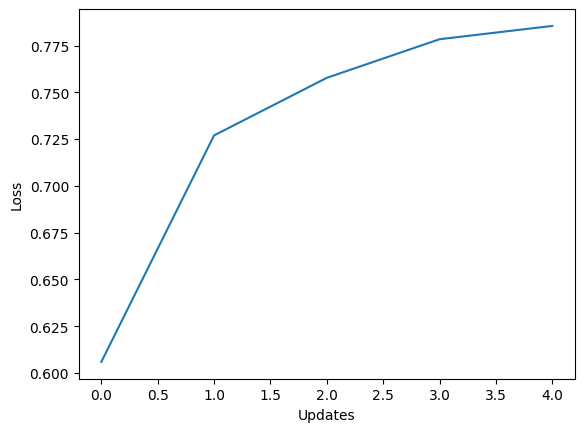

In [286]:
epoch = np.arange(len(train_losses))
plt.figure()
plt.plot(epoch, train_accuracies)
#plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Loss')

In [274]:
train_losses

[0.6625496868429512,
 [],
 0.6160800040795885,
 [],
 0.5222359697880417,
 [],
 0.48120774148867046,
 [],
 0.4642049968242645,
 []]

In [ ]:
train_en

# Prepare data

# Model

# 2b.

In [36]:
ft = fasttext.load_model('cc.en.300.bin')

In [37]:
ft.get_dimension()
ft.get_word_vector('king').shape

fasttext.util.reduce_model(ft, 80)
ft.get_dimension()

"asdasdsad" in ft.words
ft.get_nearest_neighbors('cookie')

[(0.8153295516967773, 'cupcake'),
 (0.7879170179367065, 'cookie-'),
 (0.7691606879234314, 'cookies'),
 (0.760718047618866, 'cake'),
 (0.7547473907470703, 'popover'),
 (0.7430337071418762, 'non-cookie'),
 (0.7359125018119812, 'cakepop'),
 (0.7353752255439758, 'muffin'),
 (0.7349858283996582, 'cookie.'),
 (0.7314939498901367, 'cookie.The')]

In [38]:
import spacy

In [39]:
nlp = spacy.load('en_core_web_md')

In [40]:
nlp.vocab["old"].vector.shape

(300,)

In [41]:
help(nlp)

Help on English in module spacy.lang.en object:

class English(spacy.language.Language)
 |  English(vocab: Union[spacy.vocab.Vocab, bool] = True, *, max_length: int = 1000000, meta: Dict[str, Any] = {}, create_tokenizer: Union[Callable[[ForwardRef('Language')], Callable[[str], spacy.tokens.doc.Doc]], NoneType] = None, batch_size: int = 1000, **kwargs) -> None
 |  
 |  A text-processing pipeline. Usually you'll load this once per process,
 |  and pass the instance around your application.
 |  
 |  Defaults (class): Settings, data and factory methods for creating the `nlp`
 |      object and processing pipeline.
 |  lang (str): IETF language code, such as 'en'.
 |  
 |  DOCS: https://spacy.io/api/language
 |  
 |  Method resolution order:
 |      English
 |      spacy.language.Language
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  Defaults = <class 'spacy.lang.en.EnglishDefaults'>
 |      Language data defaults, available via Language.Defaults. Can be


https://github.com/pytorch/text/issues/1350
https://christopher5106.github.io/deep/learning/2020/04/02/fasttext_pretrained_embeddings_subword_word_representations.html

In [42]:
import compress_fasttext
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from compress_fasttext.feature_extraction import FastTextTransformer

small_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load('fasttext-en-mini')

classifier = make_pipeline(
    FastTextTransformer(model=small_model), 
    LogisticRegression()
).fit(
    ['banana', 'soup', 'burger', 'car', 'tree', 'city'],
    [1, 1, 1, 0, 0, 0]
)
classifier.predict(['jet', 'train', 'cake', 'apple'])
# array([0, 0, 1, 1])

array([0, 0, 1, 1])

In [43]:
help(small_model)

Help on CompressedFastTextKeyedVectors in module compress_fasttext.compress object:

class CompressedFastTextKeyedVectors(gensim.models.fasttext.FastTextKeyedVectors)
 |  CompressedFastTextKeyedVectors(*args, **kwargs)
 |  
 |  This class extends FastTextKeyedVectors by fixing several issues:
 |  - index2word of a freshly created model is initialized from its vocab
 |  - the model does not keep heavy and useless vectors_ngrams_norm
 |  - word_vec() method with use_norm applies normalization in the right place
 |  
 |  Method resolution order:
 |      CompressedFastTextKeyedVectors
 |      gensim.models.fasttext.FastTextKeyedVectors
 |      gensim.models.keyedvectors.KeyedVectors
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Vectors and vocab for :class:`~gensim.models.fasttext.FastText`.
 |      
 |      Implements significant parts of the FastText algorithm.  For example,
 |      the :func:`word_ve

In [44]:
small_model.get_normed_vectors().shape

(20000, 300)

In [45]:
small_model.get_index("slap")

15784

In [46]:
small_model.most_similar("quantum")

[('Quantum', 0.5923356945161),
 ('physics', 0.4987263608889812),
 ('computational', 0.4833229306372649),
 ('cosmic', 0.46287664812730667),
 ('atomic', 0.4555259364535978),
 ('atoms', 0.4543258391303013),
 ('electron', 0.4415847215404407),
 ('electromagnetic', 0.4342020722504953),
 ('optical', 0.4341506741975586),
 ('physicist', 0.43388256332181196)]

In [47]:
small_model["sailor"].shape

(300,)

In [48]:
help(tok2vec)

Help on CompressedFastTextKeyedVectors in module compress_fasttext.compress object:

class CompressedFastTextKeyedVectors(gensim.models.fasttext.FastTextKeyedVectors)
 |  CompressedFastTextKeyedVectors(*args, **kwargs)
 |  
 |  This class extends FastTextKeyedVectors by fixing several issues:
 |  - index2word of a freshly created model is initialized from its vocab
 |  - the model does not keep heavy and useless vectors_ngrams_norm
 |  - word_vec() method with use_norm applies normalization in the right place
 |  
 |  Method resolution order:
 |      CompressedFastTextKeyedVectors
 |      gensim.models.fasttext.FastTextKeyedVectors
 |      gensim.models.keyedvectors.KeyedVectors
 |      gensim.utils.SaveLoad
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Vectors and vocab for :class:`~gensim.models.fasttext.FastText`.
 |      
 |      Implements significant parts of the FastText algorithm.  For example,
 |      the :func:`word_ve